In [1]:
from data_processing import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
from noise import NoiseScheduler
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from jet_finding import *
from tqdm.notebook import tqdm
import random

seed = 22
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the device to custom GPU
gpu = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # change cuda:1 to number between 0 & 5
torch.cuda.set_device(gpu)

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Number of available GPUs: 6
Current GPU: 1


In [2]:
# Set to directory where data is stored
work_home = False
data_dir = "Datasets" if work_home else "/cephfs/dice/projects/L1T/diffusion/datasets/"

start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(end_idx-start_idx, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx)

In [3]:
dataset() #once this is cached, you don't have to re-load

In [4]:
new_dim=(64,64)

saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(new_dim)     # ensure these have the same values as when the model was trained

INFO:root:re-sizing
re-sizing


In [5]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

if strip_size == 'full_image':
    y_start = 0
    y_end = 64

elif strip_size == 'strip':
    y_start = 26
    y_end = 38

In [8]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :] #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :]

In [9]:
testEvent=10

noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([40]).to(device) #each unit of timestep represents an addtional 5 pile-up events
random_seed = np.random.randint(0, end_idx-start_idx)
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[testEvent].unsqueeze(0), noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)

# Apply saturation value clipping
noisy_image = torch.clamp(noisy_image, max=saturation_value)

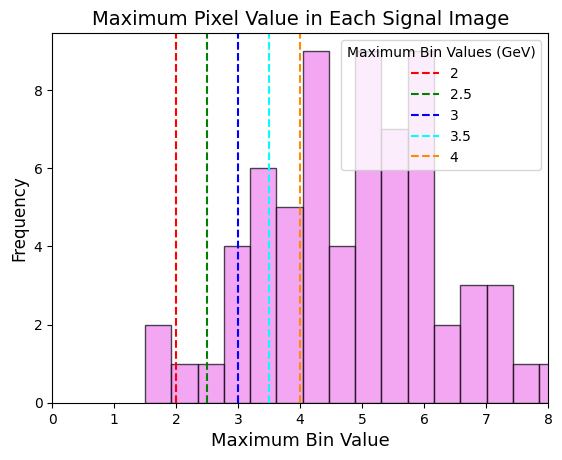

Threshold (GeV)      Perc of Events Above Threshold(%)
0.5                  100.00                   
1                    100.00                   
1.5                  99.67                    
2                    99.00                    
2.5                  98.67                    
3                    98.00                    
3.5                  95.67                    
4                    94.00                    
4.5                  90.67                    
5                    87.67                    


In [10]:
# Aside: calculate the maximum pixel value in each event loaded in the Dataset
max_bin = np.zeros(end_idx-start_idx)
for event in range(end_idx-start_idx):
    max_bin[event] = clean_frames[event].max().item()

# Plot histogram to see distribution of maximum pixel value in each event
plt.hist(max_bin, bins=1000, color='violet', alpha=0.7, edgecolor='black')
plt.title('Maximum Pixel Value in Each Signal Image', fontsize=14)
plt.xlabel('Maximum Bin Value', fontsize=13)
plt.ylabel('Frequency', fontsize=12)
thresholds = [2, 2.5, 3, 3.5, 4, 4.5, 5]
# Plot vertical lines at threshold values
plt.axvline(x=thresholds[0], color='r', linestyle='--', label=thresholds[0])
plt.axvline(x=thresholds[1], color='green', linestyle='--', label=thresholds[1])
plt.axvline(x=thresholds[2], color='blue', linestyle='--', label=thresholds[2])
plt.axvline(x=thresholds[3], color='cyan', linestyle='--', label=thresholds[3])
plt.axvline(x=thresholds[4], color='darkorange', linestyle='--', label=thresholds[4])
plt.xlim(0,8)

# Add legend
plt.legend(title='Maximum Bin Values (GeV)')
plt.show()

# Calculate the percentage of events with maximum pixel value greater than given thresholds
thresholds = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
percentages = [(max_bin > threshold).sum() / len(max_bin) * 100 for threshold in thresholds]

# Print the table
print(f"{'Threshold (GeV)':<20} {'Perc of Events Above Threshold(%)':<25}")
for threshold, percentage in zip(thresholds, percentages):
    print(f"{threshold:<20} {percentage:<25.2f}")

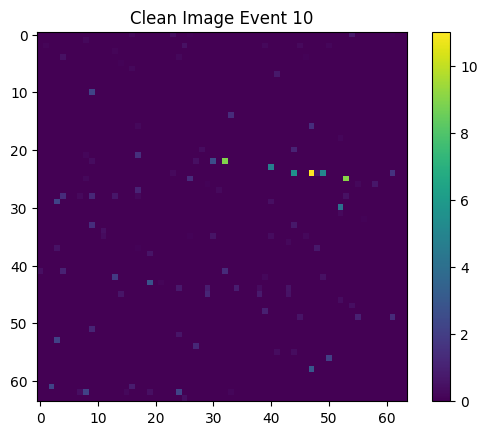

In [11]:
plt.imshow(clean_frames[testEvent].cpu().squeeze())
plt.colorbar()
plt.title(f"Clean Image Event {testEvent}")
plt.show()

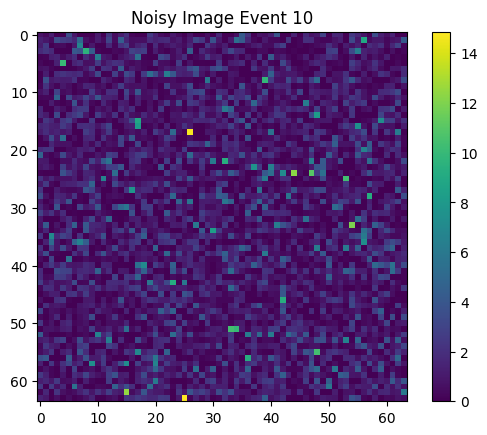

In [12]:
plt.imshow(noisy_image.squeeze().squeeze().cpu())
plt.colorbar()
plt.title(f"Noisy Image Event {testEvent}")
plt.show()

In [13]:
from models_stripped_kernels import Model, UNetLite_hls

modtype = 'UNet_lite' # Change Model type here

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
    model = model.__getitem__()

elif modtype == 'UNet_lite':
    model = UNetLite_hls()

# Move model to GPU
model = model.to(device)    

print(model)

UNetLite_hls(
  (relu): ReLU()
  (emb1): Linear(in_features=4, out_features=1, bias=True)
  (convd1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (pool1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (normd2_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb2): Linear(in_features=4, out_features=16, bias=True)
  (convd2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_3): GroupNorm(8, 16, eps=1e-05, affine=True)
  (pool2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (normb1_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb4): Linear(in_features=4, out_features=16, bias=True)
  (convb1_1

/software/sa21722/miniconda3/envs/sd_env/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [14]:
if modtype == 'UNet2d':
    # Use 1st line for huggingface trained model
    # Use 2nd line for retrained model

    trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
    #trained_model_path = 'retrained_models_UNet2d/saturation=512/model_epoch_9.pt'

elif modtype == 'UNet_lite': 
    trained_model_path = 'trained_models_lite/const_kernels_16/model_epoch_9.pt' # Specify folder for which trained model here!

print(trained_model_path)

trained_models_lite/const_kernels_16/model_epoch_9.pt


In [15]:
checkpoint = torch.load(trained_model_path, map_location=device)  # Ensure checkpoint is loaded to the correct device
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [16]:
noisy_image = noisy_image.to(device)
if modtype == 'UNet2d':
    noise_pred = model(noisy_image, timestep, return_dict=False)[0]
elif modtype == 'UNet_lite':
    noise_pred = model(noisy_image, timestep)

In [17]:
de_noised = F.relu(noisy_image - noise_pred)

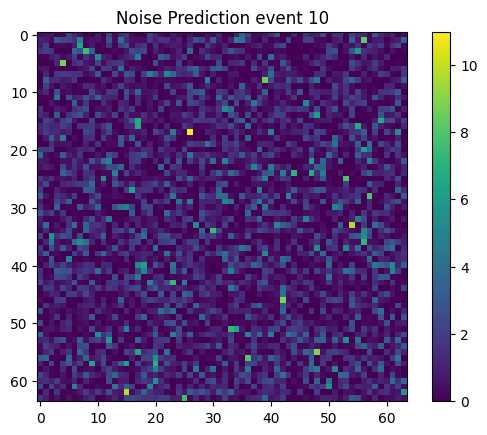

In [18]:
# Display the noise prediction
ims = plt.imshow(noise_pred.detach().squeeze().squeeze().cpu()) # Move prediction back to CPU for visualization
plt.colorbar(ims)
plt.title(f"Noise Prediction event {testEvent}")
plt.show()

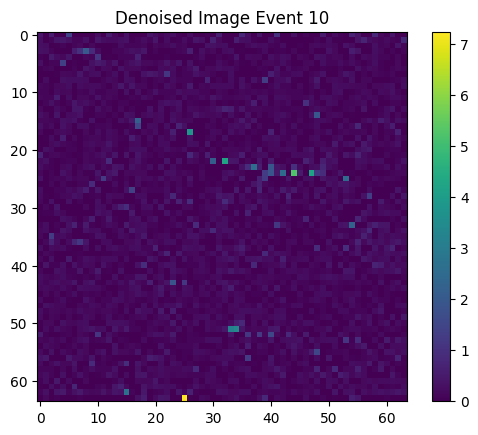

In [19]:
im = plt.imshow(de_noised.detach().cpu().squeeze().squeeze())
plt.colorbar(im)
plt.title(f"Denoised Image Event {testEvent}")
plt.show()

In [20]:
local_maxima, jets_clean = find_local_maxima(clean_frames[testEvent].unsqueeze(0), 9)
print(local_maxima)

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]


Number of local maxima:  3


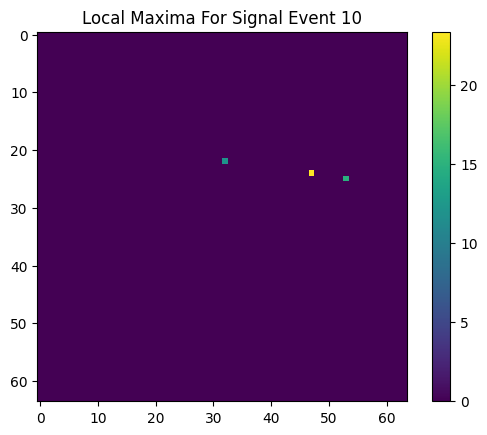

In [21]:
plt.imshow(local_maxima.squeeze().squeeze())
print('Number of local maxima: ', len(jets_clean))
plt.colorbar()
plt.title(f"Local Maxima For Signal Event {testEvent}")
plt.show()

Number of local maxima:  15


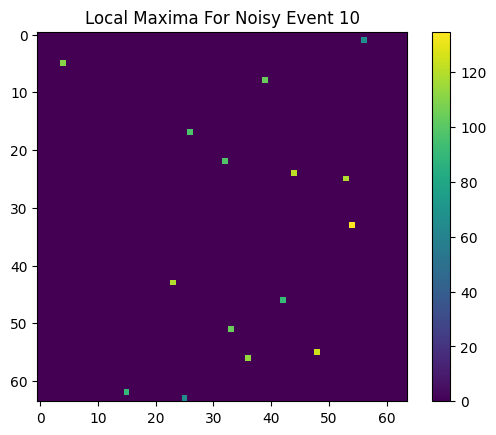

In [22]:
local_maxima, jets_noisy = find_local_maxima(noisy_image, 9)
print ('Number of local maxima: ', len(jets_noisy))
plt.imshow(local_maxima.squeeze().squeeze())
plt.colorbar()
plt.title(f"Local Maxima For Noisy Event {testEvent}")
plt.show()

Number of local maxima:  2


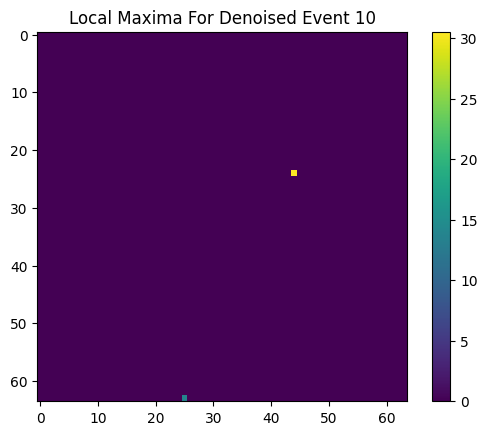

In [23]:

local_maxima, jets_denoised = find_local_maxima(de_noised.detach(), 9)
print ('Number of local maxima: ', len(jets_denoised))
plt.imshow(local_maxima.squeeze().squeeze())
plt.colorbar()
plt.title(f"Local Maxima For Denoised Event {testEvent}")
plt.show()

In [24]:
print (jets_denoised)

[{'event': 0, 'i': 24, 'j': 44, 'pixel_value': 5.2449474, 'sum_around_maxima': 30.518566}, {'event': 0, 'i': 63, 'j': 25, 'pixel_value': 7.246969, 'sum_around_maxima': 13.739858}]


Reference Maxima: {'event': 0, 'i': 22, 'j': 32, 'pixel_value': 8.925471, 'sum_around_maxima': 12.013487}, Test Maxima: {'event': 0, 'i': 22, 'j': 32, 'pixel_value': 9.337452, 'sum_around_maxima': 98.361984}
Reference Maxima: {'event': 0, 'i': 25, 'j': 53, 'pixel_value': 9.065568, 'sum_around_maxima': 14.822347}, Test Maxima: {'event': 0, 'i': 25, 'j': 53, 'pixel_value': 10.35251, 'sum_around_maxima': 118.61236}


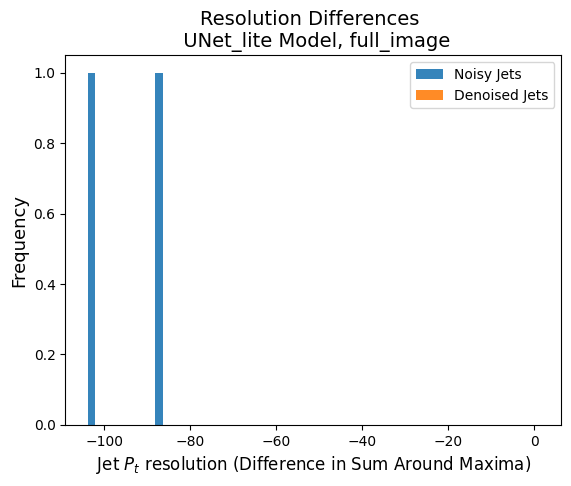

In [25]:
differences_allJetTypes = []
for test_jets in [jets_noisy, jets_denoised]:
    matching_jets = find_matching_maxima(jets_clean, test_jets)
    
    for ref_maxima, test_maxima_entry in matching_jets:
        print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

    differences = [ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                   for ref_maxima, test_maxima_entry in matching_jets]
    differences_allJetTypes.append(differences)

# Plot histograms for each set of differences
for differences, label in zip(differences_allJetTypes, ['Noisy Jets', 'Denoised Jets']):
        plt.hist(differences, alpha=0.9, label=label)

plt.title(f'Resolution Differences \n {modtype} Model, {strip_size}', fontsize=14)
plt.xlabel('Jet $P_t$ resolution (Difference in Sum Around Maxima)', fontsize=12)
plt.ylabel('Frequency', fontsize=13)
plt.legend()
plt.show()

In [26]:
# Assuming clean_frames, model, device, saturation_value, pile_up, modtype, and NoiseScheduler are defined
num_events = end_idx - start_idx
batch_size = 100  # Process all events in a single batch

# Create DataLoader
inference_dataset = TensorDataset(clean_frames)
inference_dataloader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

# Pre-allocate lists for differences
jets_clean = []
jets_noisy = []
jets_denoised = []
jets_denoised_partial = []
differences_allJetTypes = []
differences_jets_noisy = []
differences_jets_denoised = []
differences_jets_denoised_partial = []

progress_bar = tqdm(total=num_events//batch_size, desc="Local Maxima Finding")

# Processing batches
for batch_idx, (clean_batch,) in enumerate(inference_dataloader):
    clean_batch = clean_batch.to(device)
    random_seed = np.random.randint(0, end_idx - start_idx)
    timestep = torch.LongTensor([40]).to(device)

    # Generate the noisy image for the batch
    noise_scheduler = NoiseScheduler('pile-up')
    noisy_images, noise = noise_scheduler.add_noise(
        clean_frame=clean_batch,
        noise_sample=pile_up,
        timestep=timestep,
        random_seed=random_seed,
        n_events=num_events
    )

    # Apply saturation value clipping and scaling
    noisy_images = torch.clamp(noisy_images, max=saturation_value)

    if modtype == 'UNet2d':
        noise_pred = model(noisy_images, timestep, return_dict=False)[0]
    elif modtype == 'UNet_lite':
        noise_pred = model(noisy_images, timestep)

    de_noised = F.relu(noisy_images - noise_pred)

    # Generate partially denoised images
    timestep_partial = torch.LongTensor([1]).to(device)
    if modtype == 'UNet2d':
        noise_pred_partial = model(noisy_images, timestep_partial, return_dict=False)[0]
    elif modtype == 'UNet_lite':
        noise_pred_partial = model(noisy_images, timestep_partial)

    de_noised_partial = F.relu(noisy_images - noise_pred_partial)

    # Process each image in the batch
    local_maxima_clean, jets_clean = find_local_maxima(clean_batch, 9)
    local_maxima_noisy, jets_noisy = find_local_maxima(noisy_images, 9)
    local_maxima_denoised, jets_denoised = find_local_maxima(de_noised.detach(), 9)
    local_maxima_partial, jets_denoised_partial = find_local_maxima(de_noised_partial.detach(), 9)

    matching_jets_noisy = find_matching_maxima(jets_clean, jets_noisy)
    matching_jets_denoised = find_matching_maxima(jets_clean, jets_denoised)
    matching_jets_denoised_partial = find_matching_maxima(jets_clean, jets_denoised_partial)

    differences_jets_noisy.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                                   for ref_maxima, test_maxima_entry in matching_jets_noisy])
    differences_jets_denoised.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                                      for ref_maxima, test_maxima_entry in matching_jets_denoised])
    differences_jets_denoised_partial.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                                              for ref_maxima, test_maxima_entry in matching_jets_denoised_partial])
    progress_bar.update(1)
    logs = {"Batch": batch_idx+1}
    progress_bar.set_postfix(**logs)
progress_bar.close()
    # Visualization for debugging, Uncomment if needed
    # for event in range(clean_batch.size(0)):
    #     fig, axs = plt.subplots(1, 5, figsize=(40, 6))

    #     im0 = axs[0].imshow(clean_batch[event].cpu().squeeze())
    #     axs[0].set_title(f"Clean Image Event {event}")
    #     fig.colorbar(im0, ax=axs[0])

    #     im1 = axs[1].imshow(local_maxima_clean[event].squeeze())
    #     axs[1].set_title(f"Local Maxima For Signal Event {event}")
    #     fig.colorbar(im1, ax=axs[1])

    #     im2 = axs[2].imshow(de_noised[event].detach().cpu().squeeze())
    #     axs[2].set_title(f"Denoised Image Event {event}")
    #     fig.colorbar(im2, ax=axs[2])

    #     im3 = axs[3].imshow(local_maxima_denoised[event].squeeze())
    #     axs[3].set_title(f"Local Maxima For Denoised Event {event}")
    #     fig.colorbar(im3, ax=axs[3])
    
    #     im4 = axs[4].imshow(noise[event].cpu().squeeze()) # Check noise pattern added different for each event
    #     axs[4].set_title(f"Noise Added to Event {event}")
    #     fig.colorbar(im3, ax=axs[4])

    #     plt.show()

Local Maxima Finding:   0%|          | 0/3 [00:00<?, ?it/s]

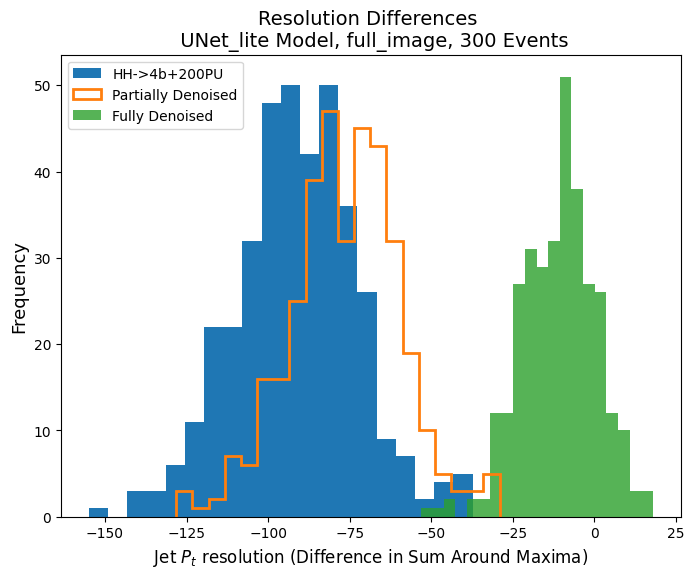

In [27]:
# Plot histograms for each set of differences
plt.figure(figsize=(8, 6))
plt.hist(differences_jets_noisy, bins=20, label='HH->4b+200PU')
plt.hist(differences_jets_denoised_partial, bins=20, label='Partially Denoised', histtype='step', linewidth=2)
plt.hist(differences_jets_denoised, bins=20, alpha=0.8, label='Fully Denoised')
plt.title(f'Resolution Differences \n {modtype} Model, {strip_size}, {num_events} Events', fontsize=14)
plt.xlabel('Jet $P_t$ resolution (Difference in Sum Around Maxima)', fontsize=12)
plt.ylabel('Frequency', fontsize=13)
plt.legend()
plt.show()

In [28]:
print(differences_jets_denoised)

[-11.133453, -7.431037, -13.703941, -9.230675, -19.290161, -22.766014, -3.6693344, -2.46875, -18.839027, -6.592926, -24.585236, 8.483994, -10.486649, -13.445953, -0.14310455, -19.252983, -11.543518, -16.582077, -8.034172, -8.693237, -1.8427124, -13.899139, -18.75372, 8.8940735, -19.487522, -5.4535065, -10.530563, -22.145317, 17.346985, -13.316544, -19.071915, -30.740372, -8.180918, -19.38433, -22.210583, -13.428223, -22.424881, 8.7282295, -23.751709, -36.56665, -17.48529, -22.552368, -23.22033, -18.077713, -12.4835205, -25.529053, -12.007889, -9.261429, -27.649872, -21.434456, -28.618729, -15.928146, 2.8733635, -21.235641, -3.8981934, -14.734116, 2.6549683, -20.059189, -21.53379, -10.967457, -23.661312, 5.134983, 6.1133575, 2.3365822, 0.37606812, -0.60466385, -14.161282, -27.520935, -3.049286, -30.822807, -19.105759, -11.385159, 7.6724625, -3.4076843, 1.0142212, -21.530361, -18.516808, -10.051369, -7.935158, -9.485886, -22.456734, -31.333384, -11.582062, -12.967651, -5.77184, -21.86343

In [29]:

# The jet with the maximum sum_around_maxima is identified as the leading jet for both noisy and denoised images
# Initialize lists to hold the leading jets for each event
leading_jet_noisy = []
leading_jet_denoised = []

# Group the jets by event
jets_noisy_by_event = {}
jets_denoised_by_event = {}

# Populate the dictionaries with lists of jets for each event
for jet in jets_noisy:
    event = jet['event']
    if event not in jets_noisy_by_event:
        jets_noisy_by_event[event] = []
    jets_noisy_by_event[event].append(jet)

for jet in jets_denoised:
    event = jet['event']
    if event not in jets_denoised_by_event:
        jets_denoised_by_event[event] = []
    jets_denoised_by_event[event].append(jet)

# Find the leading jets for noisy images
for event, jets in jets_noisy_by_event.items():
    max_pt_jet = max(jets, key=lambda x: x['sum_around_maxima'])
    leading_jet_noisy.append(max_pt_jet)

# Find the leading jets for denoised images
for event, jets in jets_denoised_by_event.items():
    max_pt_jet = max(jets, key=lambda x: x['sum_around_maxima'])
    leading_jet_denoised.append(max_pt_jet)

# Example print to verify the results
print(leading_jet_noisy[22])
print(leading_jet_denoised[22])


{'event': 67, 'i': 3, 'j': 4, 'pixel_value': 14.574094, 'sum_around_maxima': 150.69514}
{'event': 50, 'i': 3, 'j': 21, 'pixel_value': 17.234669, 'sum_around_maxima': 57.44639}


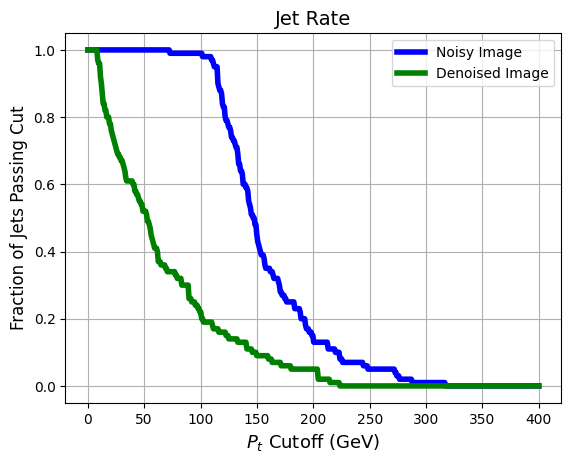

In [30]:
cut_values = np.linspace(0, 400, 500)

pt_values_noisy = [jet['sum_around_maxima'] for jet in leading_jet_noisy]
fraction_passing_noisy = [sum(pt >= cut for pt in pt_values_noisy) / len(pt_values_noisy) for cut in cut_values]

pt_values_denoised = [jet['sum_around_maxima'] for jet in leading_jet_denoised]
fraction_passing_denoised = [sum(pt >= cut for pt in pt_values_denoised) / len(pt_values_denoised) for cut in cut_values]

plt.plot(cut_values, fraction_passing_noisy, linewidth = 4, color='b', label='Noisy Image')
plt.plot(cut_values, fraction_passing_denoised, linewidth = 4, color='g', label='Denoised Image')
plt.title('Jet Rate', fontsize = 14)
plt.xlabel('$P_t$ Cutoff (GeV)', fontsize = 13)
plt.ylabel('Fraction of Jets Passing Cut', fontsize = 12)
plt.legend()
plt.grid(True)
plt.show()